##### This is a sample notebook showing how to train the ML models for XPFS/XPCS single-photon counting experiments. For the training, please extract the dataset at: https://zenodo.org/record/6643622 to the ml_xpfs folder.

In [1]:
%load_ext autoreload
%autoreload 2

import h5py
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback
from scipy.optimize import minimize
from scipy.misc import derivative

from tqdm import tqdm
from unet_model import *
from utils import *

In [2]:
# Load data
hf = h5py.File('../XPFS_data/high_kbar/high_kbar.h5', 'r')

The following three cells breaks down the h5 file structure. Please note that the valid and test data have 18 datasets respectively. Each dataset corresponds to a particular contrast level.

In [3]:
print(hf.keys())

<KeysViewHDF5 ['test', 'train', 'valid']>


In [4]:
print(hf['train'].keys())

<KeysViewHDF5 ['train_detector', 'train_photon_map']>


In [5]:
print(hf['valid'].keys())

<KeysViewHDF5 ['valid_detector_0.1', 'valid_detector_0.15', 'valid_detector_0.2', 'valid_detector_0.25', 'valid_detector_0.3', 'valid_detector_0.35', 'valid_detector_0.4', 'valid_detector_0.45', 'valid_detector_0.5', 'valid_detector_0.55', 'valid_detector_0.6', 'valid_detector_0.65', 'valid_detector_0.7', 'valid_detector_0.75', 'valid_detector_0.8', 'valid_detector_0.85', 'valid_detector_0.9', 'valid_detector_0.95', 'valid_photon_map_0.1', 'valid_photon_map_0.15', 'valid_photon_map_0.2', 'valid_photon_map_0.25', 'valid_photon_map_0.3', 'valid_photon_map_0.35', 'valid_photon_map_0.4', 'valid_photon_map_0.45', 'valid_photon_map_0.5', 'valid_photon_map_0.55', 'valid_photon_map_0.6', 'valid_photon_map_0.65', 'valid_photon_map_0.7', 'valid_photon_map_0.75', 'valid_photon_map_0.8', 'valid_photon_map_0.85', 'valid_photon_map_0.9', 'valid_photon_map_0.95']>


In [6]:
# Custom callback for contrast calculation on 18 validation sets every 10 epochs. 
# This is a useful check that the model is actually learning contrast and not just MSE 

class ContrastEvaluation(Callback):
    def __init__(self):
        super(Callback, self).__init__()

    def on_epoch_end(self,epochs,logs=None):
                
        # Validation Set Contrast 
        if (epochs % 10 == 0):
            
            true = list(np.round(np.linspace(0.1, 0.95, 18), 2))
            
            ml_pred = []
            
            for element in true:
                X_ADU_test = np.array(hf['valid']['valid_detector_' + str(element)])                 
                photon_map = np.round(model.predict(X_ADU_test))
                data = np.reshape(photon_map, (len(photon_map), -1))
                k = np.reshape(data, -1)
                kbar = np.repeat(np.mean(data, axis=1),900)
                result = minimize(nll,0.8,args=(k,kbar),bounds=((0.001,1.0),))
                ml_pred.append(result.x[0])
                
            corr, _ = pearsonr(ml_pred, true)
            print(str(epochs))
            print("Correlation: ", corr)
            
            plt.scatter(true, ml_pred)
            plt.plot(np.linspace(0,1), np.linspace(0,1), color='red')
            plt.xlabel("True")
            plt.ylabel("Predicted")
            plt.xlim(0,1)
            plt.ylim(0,1)
            plt.show()
        
            print("------------------------------------------------------------------------------------")

In [7]:
# Load training data; already normalized to a photon ADU = 340
X_train_ADU = np.array(hf['train']['train_detector'])
X_train_GT = np.array(hf['train']['train_photon_map'])


Train model

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 90, 90, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 90, 90, 8)    80          ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 90, 90, 8)   32          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 tf.nn.relu (TFOpLambda)        (None, 90, 90, 8)    0           ['batch_normalization[0][0]']

0epoch [00:00, ?epoch/s]

0
Correlation:  0.9977171399608573


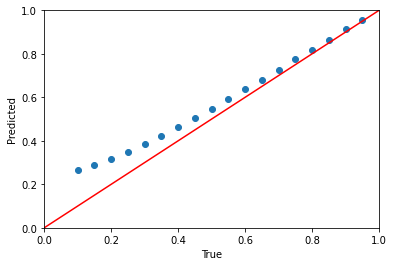

------------------------------------------------------------------------------------


In [ ]:
input_shape = (90, 90, 1)

ce = ContrastEvaluation()

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model = build_unet(input_shape)
model.summary()
model.compile(loss='mse', metrics='mse', optimizer=opt)
history = model.fit(X_train_ADU, X_train_GT, validation_split = 0.1, epochs=50, shuffle=True,batch_size=128, verbose=0, callbacks=[ce, TqdmCallbackFix(verbose=0)])

In [ ]:
# Plot training and validation loss history 
figure(figsize=(8, 8), dpi=80)
plt.plot(history.history['mse'], label = 'Training Mean Squared Error')
plt.plot(history.history['val_mse'], label = 'Validation Mean Squared Error')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(fontsize=16)
plt.show()